# Synthetic Mogi InSAR Data & Inversion

This notebook simulates synthetic InSAR data from a one‑source Mogi model and then conducts inversions using three different approaches:

1. **Grid Search Inversion**
2. **Undirected Monte Carlo Inversion**
3. **Directed Monte Carlo Inversion**

The inversion domain is set to horizontal coordinates from -4000 to 4000 m and vertical coordinate from 0 to 2000 m. For each trial model a linear inversion is performed for the source strength (dV).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import pi
from scipy.fftpack import fft2, ifft2

# Set random seed for reproducibility
np.random.seed(42)

# Configure inline plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['font.size'] = 12

## 1. Synthetic Data Generation

We create a 10 km × 10 km grid with 50 m spacing and define a function for the Mogi source displacements. The vertical displacement is given by:

  \( u_z = \frac{(1-\nu)dV}{\pi} \; \frac{z_0}{(r^2+z_0^2)^{3/2}} \), where \( r = \sqrt{(x-x_0)^2+(y-y_0)^2} \).

We choose \( dV = 0.20\,\pi\,z_0^2/(1-\nu) \) so that the source produces 20 cm uplift directly over it if acting alone. The true model is a source at (0,0) with a depth of 1000 m.

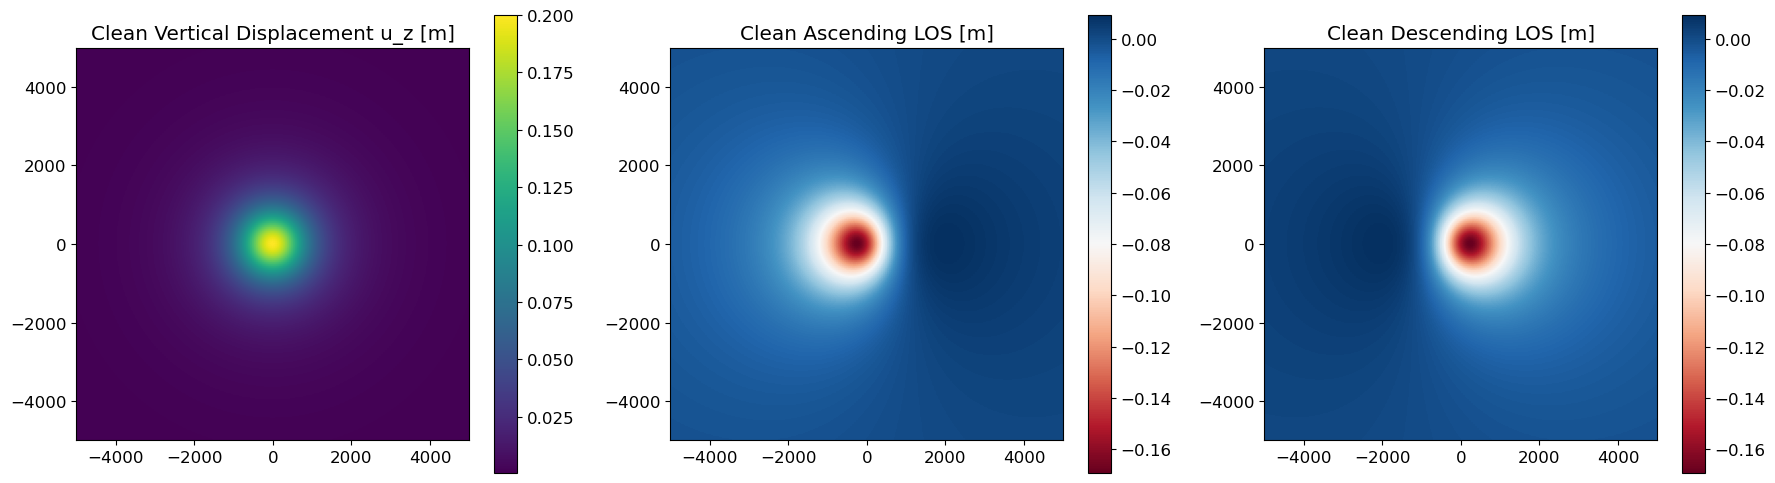

In [2]:
def mogi_displacement(x_obs, y_obs, x0, y0, z0, dV, nu=0.25):
    """Compute vertical (u_z) and eastward (u_E) displacements at (x_obs, y_obs) for a Mogi source."""
    dx = x_obs - x0
    dy = y_obs - y0
    r = np.sqrt(dx**2 + dy**2)
    R = np.sqrt(r**2 + z0**2)
    uz = (1 - nu) * dV / pi * (z0 / R**3)
    ur = (1 - nu) * dV / pi * (r / R**3)
    # Compute eastward displacement (avoid division by zero)
    uE = np.zeros_like(ur)
    nonzero = (r > 1e-10)
    uE[nonzero] = ur[nonzero] * (dx[nonzero] / r[nonzero])
    return uz, uE

# Create a 10 km x 10 km grid (50 m spacing)
dx = 50
x = np.arange(-5000, 5000 + dx, dx)
y = np.arange(-5000, 5000 + dx, dx)
X, Y = np.meshgrid(x, y)

# True model parameters
true_x, true_y, true_z = 0.0, 0.0, 1000.0
nu = 0.25
dV_true = 0.20 * pi * true_z**2 / (1 - nu)

# Compute noise-free displacements
Uz, uE = mogi_displacement(X, Y, true_x, true_y, true_z, dV_true, nu)

# Convert to radar LOS for ascending and descending geometries
inc = np.deg2rad(40)
LOS_asc = -Uz * np.cos(inc) + uE * np.sin(inc)
LOS_desc = -Uz * np.cos(inc) - uE * np.sin(inc)

# Plot the clean synthetic data
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
im0 = ax[0].imshow(Uz, cmap='viridis', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
ax[0].set_title('Clean Vertical Displacement u_z [m]')
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(LOS_asc, cmap='RdBu', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
ax[1].set_title('Clean Ascending LOS [m]')
fig.colorbar(im1, ax=ax[1])
im2 = ax[2].imshow(LOS_desc, cmap='RdBu', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
ax[2].set_title('Clean Descending LOS [m]')
fig.colorbar(im2, ax=ax[2])
plt.tight_layout()
plt.show()

# Save clean LOS data for later use
los_asc_clean = LOS_asc.copy()
los_desc_clean = LOS_desc.copy()

## 2. Add Noise Using a Power-Law Noise Model

We now add synthetic noise to the LOS data using a 2D power‑law noise model. The noise parameters are:
  - **noise_exponent**: (spectral exponent, default = 2.0)
  - **noise_amplitude**: (amplitude in meters, default = 0.02 m)

You can modify these parameters as needed.

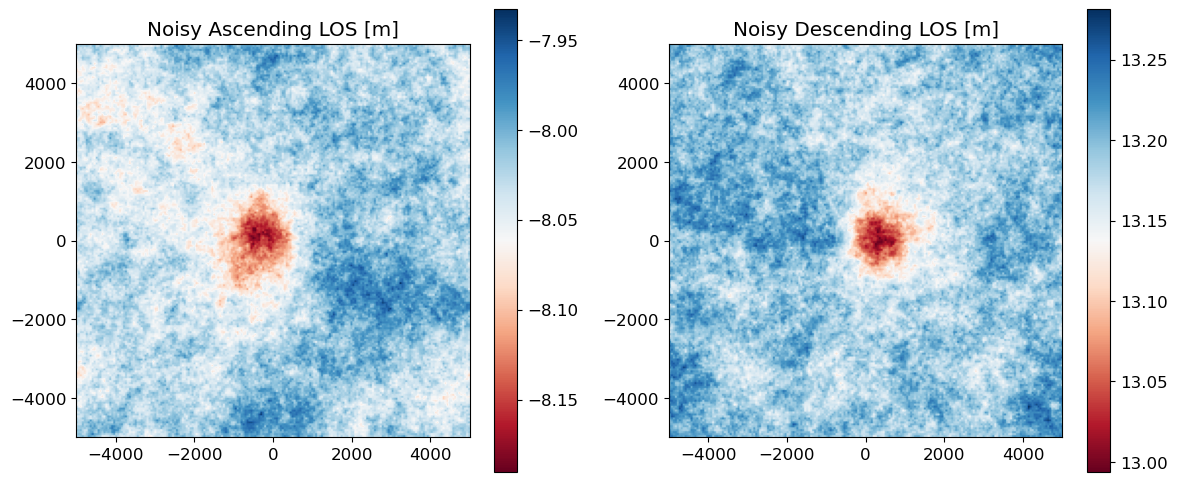

In [3]:
def power_law_noise(shape, exponent=2.0, amplitude=0.02):
    noise = np.random.randn(*shape)
    f_noise = fft2(noise)
    fx = np.fft.fftfreq(shape[0])
    fy = np.fft.fftfreq(shape[1])
    FX, FY = np.meshgrid(fx, fy, indexing='ij')
    radius = np.sqrt(FX**2 + FY**2)
    radius[0, 0] = 1e-6
    f_noise = f_noise / radius**(exponent/2)
    noise = np.real(ifft2(f_noise))
    noise = amplitude * noise / np.std(noise)
    return noise

# Set noise parameters
noise_exponent = 2.0
noise_amplitude = 0.02

LOS_asc_noisy = los_asc_clean + power_law_noise(los_asc_clean.shape, exponent=noise_exponent, amplitude=noise_amplitude)
LOS_desc_noisy = los_desc_clean + power_law_noise(los_desc_clean.shape, exponent=noise_exponent, amplitude=noise_amplitude)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im = ax[0].imshow(LOS_asc_noisy, cmap='RdBu', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
ax[0].set_title('Noisy Ascending LOS [m]')
fig.colorbar(im, ax=ax[0])
im = ax[1].imshow(LOS_desc_noisy, cmap='RdBu', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
ax[1].set_title('Noisy Descending LOS [m]')
fig.colorbar(im, ax=ax[1])
plt.tight_layout()
plt.show()


## 3. Downsample Data

Downsample the noisy interferograms (50 m spacing) to 500 m spacing by taking every 10th sample. The downsampled data are plotted using nearest‑neighbor interpolation so that each data point appears as a square (with no gaps).

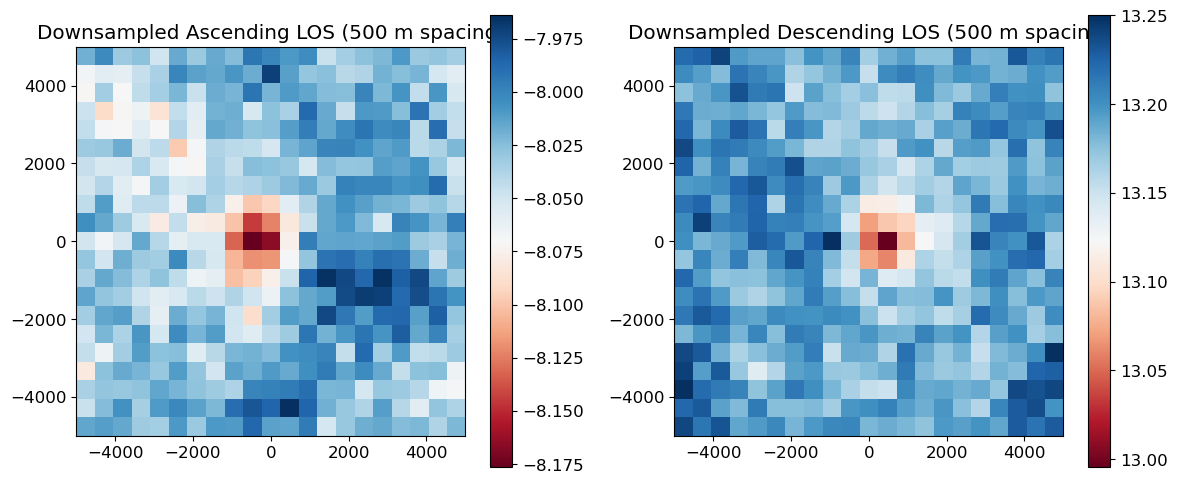

In [4]:
step = 10  # 500 m / 50 m
X_ds = X[::step, ::step]
Y_ds = Y[::step, ::step]
asc_ds = LOS_asc_noisy[::step, ::step]
desc_ds = LOS_desc_noisy[::step, ::step]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im = ax[0].imshow(asc_ds, cmap='RdBu', extent=[X_ds.min(), X_ds.max(), Y_ds.min(), Y_ds.max()], origin='lower', interpolation='nearest')
ax[0].set_title('Downsampled Ascending LOS (500 m spacing)')
fig.colorbar(im, ax=ax[0])
im = ax[1].imshow(desc_ds, cmap='RdBu', extent=[X_ds.min(), X_ds.max(), Y_ds.min(), Y_ds.max()], origin='lower', interpolation='nearest')
ax[1].set_title('Downsampled Descending LOS (500 m spacing)')
fig.colorbar(im, ax=ax[1])
plt.tight_layout()
plt.show()


## 4. Inversion Approach 1: Grid Search Inversion (One-Source Model)

We now perform a grid search inversion over the domain:
  - Horizontal: x,y ∈ [-4000, 4000] m (step = 200 m)
  - Vertical: z ∈ [200, 2000] m (step = 200 m)

For each candidate (x,y,z) we compute the unit LOS response (assuming unit dV) and then solve for the best dV by
  \( dV_{best} = \frac{\sum_i F_i d_i}{\sum_i F_i^2} \).

The misfit is computed as:
  \( E = \sum_i (d_i - dV_{best}F_i)^2 \).

For each candidate depth, the best model is recorded and then the overall best one‑source model is printed. Using the best model, the observed, predicted, and residual ascending LOS fields are plotted (with the plots restricted to x,y ∈ [-4000,4000] and using the downsampled data).

Depth 200 m: Best (x,y) = (3400.0, 200.0), dV = 1.821e+07, misfit = 2.771e+04
Depth 400 m: Best (x,y) = (3800.0, 200.0), dV = 3.117e+07, misfit = 2.701e+04
Depth 600 m: Best (x,y) = (4000.0, 200.0), dV = 5.792e+07, misfit = 2.584e+04
Depth 800 m: Best (x,y) = (4000.0, 200.0), dV = 9.681e+07, misfit = 2.436e+04
Depth 1000 m: Best (x,y) = (4000.0, 200.0), dV = 1.426e+08, misfit = 2.278e+04
Depth 1200 m: Best (x,y) = (4000.0, 0.0), dV = 1.938e+08, misfit = 2.121e+04
Depth 1400 m: Best (x,y) = (3800.0, 0.0), dV = 2.495e+08, misfit = 1.966e+04
Depth 1600 m: Best (x,y) = (3800.0, 0.0), dV = 3.094e+08, misfit = 1.815e+04
Depth 1800 m: Best (x,y) = (3600.0, 0.0), dV = 3.730e+08, misfit = 1.668e+04
Depth 2000 m: Best (x,y) = (3400.0, 0.0), dV = 4.396e+08, misfit = 1.530e+04

Overall best one-source model: Depth = 2000 m, (x,y) = (3400.0, 0.0), dV = 4.396e+08, misfit = 1.530e+04


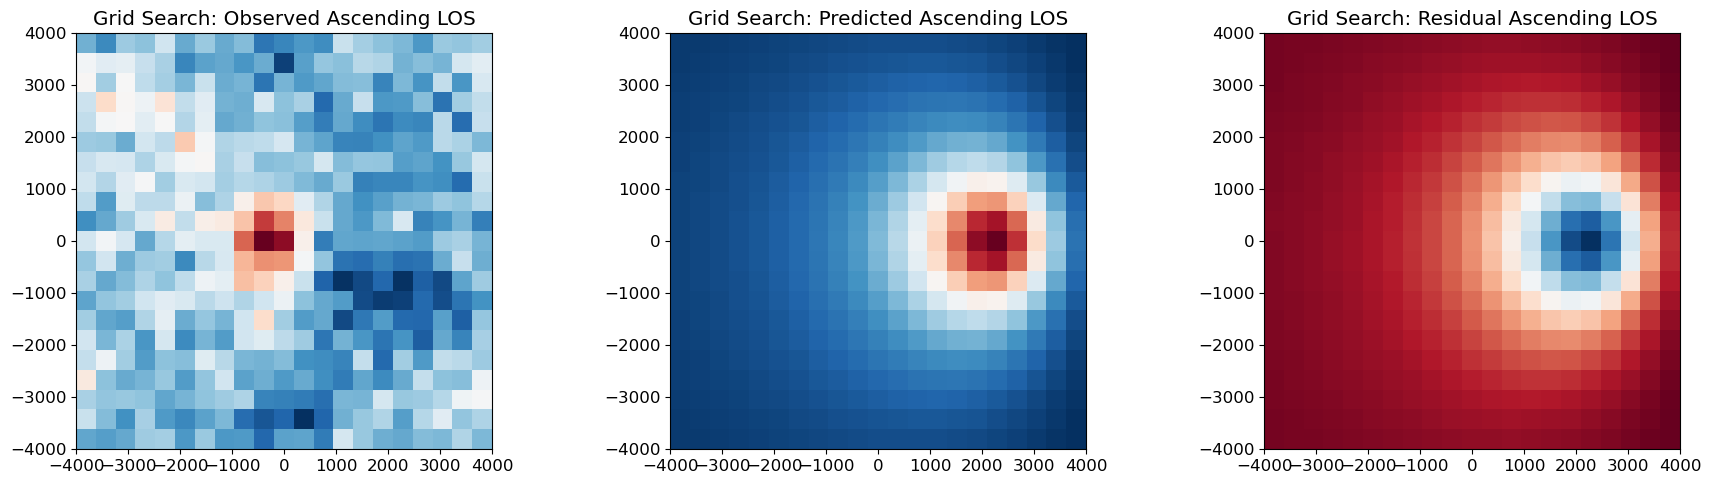

In [5]:
# Observed data from downsampled ascending LOS
obs_x = X_ds.flatten()
obs_y = Y_ds.flatten()
obs_data = asc_ds.flatten()

# Define candidate grid
x_grid = np.arange(-4000, 4001, 200)
y_grid = np.arange(-4000, 4001, 200)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Candidate depths
z_grid = np.arange(200, 2001, 200)

misfit_grid = np.empty((len(x_grid), len(y_grid), len(z_grid)))
dV_grid = np.empty_like(misfit_grid)

for k, z0 in enumerate(z_grid):
    for i, x0 in enumerate(x_grid):
        for j, y0 in enumerate(y_grid):
            # Compute unit LOS response for candidate model (with unit dV)
            uz_candidate, ux_candidate = mogi_displacement(obs_x, obs_y, x0, y0, z0, 1.0, nu)
            F = -uz_candidate * np.cos(inc) + ux_candidate * np.sin(inc)
            # Linear inversion for dV
            denom = np.dot(F, F)
            dV_est = np.dot(F, obs_data) / denom if denom != 0 else 0.0
            dV_grid[i, j, k] = dV_est
            model = dV_est * F
            misfit_grid[i, j, k] = np.sum((obs_data - model)**2)

# For each candidate depth, record best model
best_models = {}
overall_best = None
overall_misfit = np.inf
best_depth = None
for k, z0 in enumerate(z_grid):
    idx = np.unravel_index(np.argmin(misfit_grid[:, :, k]), (len(x_grid), len(y_grid)))
    best_models[z0] = (x_grid[idx[0]], y_grid[idx[1]], dV_grid[idx[0], idx[1], k], misfit_grid[idx[0], idx[1], k])
    print(f"Depth {z0} m: Best (x,y) = ({best_models[z0][0]:.1f}, {best_models[z0][1]:.1f}), dV = {best_models[z0][2]:.3e}, misfit = {best_models[z0][3]:.3e}")

for z0 in z_grid:
    if best_models[z0][3] < overall_misfit:
        overall_misfit = best_models[z0][3]
        overall_best = best_models[z0]
        best_depth = z0

print(f"\nOverall best one-source model: Depth = {best_depth} m, (x,y) = ({overall_best[0]:.1f}, {overall_best[1]:.1f}), dV = {overall_best[2]:.3e}, misfit = {overall_misfit:.3e}")

# Compute predicted ascending LOS and residuals using the overall best model
best_x, best_y, best_dV, _ = overall_best
uz_best, ux_best = mogi_displacement(obs_x, obs_y, best_x, best_y, best_depth, 1.0, nu)
F_best = -uz_best * np.cos(inc) + ux_best * np.sin(inc)
pred_asc = best_dV * F_best
res_asc = obs_data - pred_asc

# Reshape predictions and residuals for plotting
pred_asc_grid = pred_asc.reshape(asc_ds.shape)
res_asc_grid = res_asc.reshape(asc_ds.shape)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
im = ax[0].imshow(asc_ds, cmap='RdBu', extent=[-4000, 4000, -4000, 4000], origin='lower', interpolation='nearest')
ax[0].set_title('Grid Search: Observed Ascending LOS')
im = ax[1].imshow(pred_asc_grid, cmap='RdBu', extent=[-4000, 4000, -4000, 4000], origin='lower', interpolation='nearest')
ax[1].set_title('Grid Search: Predicted Ascending LOS')
im = ax[2].imshow(res_asc_grid, cmap='RdBu', extent=[-4000, 4000, -4000, 4000], origin='lower', interpolation='nearest')
ax[2].set_title('Grid Search: Residual Ascending LOS')
plt.tight_layout()
plt.show()


## 5. Inversion Approach 2: Undirected Monte Carlo Inversion (One-Source Model)

Next, we perform an undirected Monte Carlo inversion by drawing 1000 candidate models uniformly from the inversion domain:
  - x, y ∈ [-4000, 4000] m
  - z ∈ [0, 2000] m

For each candidate, we perform a linear inversion for dV and compute the misfit. Then, we plot the marginal probability distributions (weighted by 1/misfit) and pairwise covariance scatter plots (with axes set to the entire domain) and print the best model parameters.

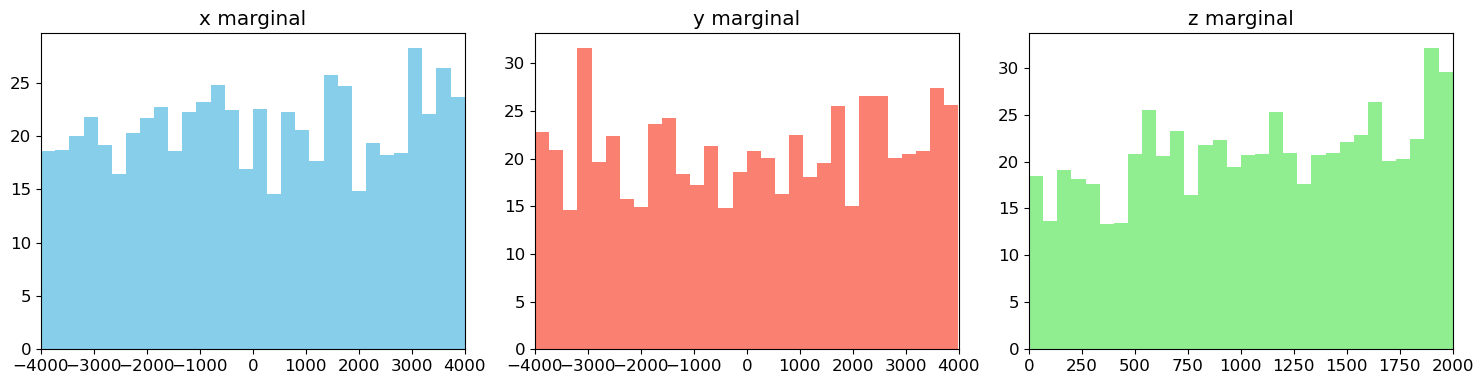

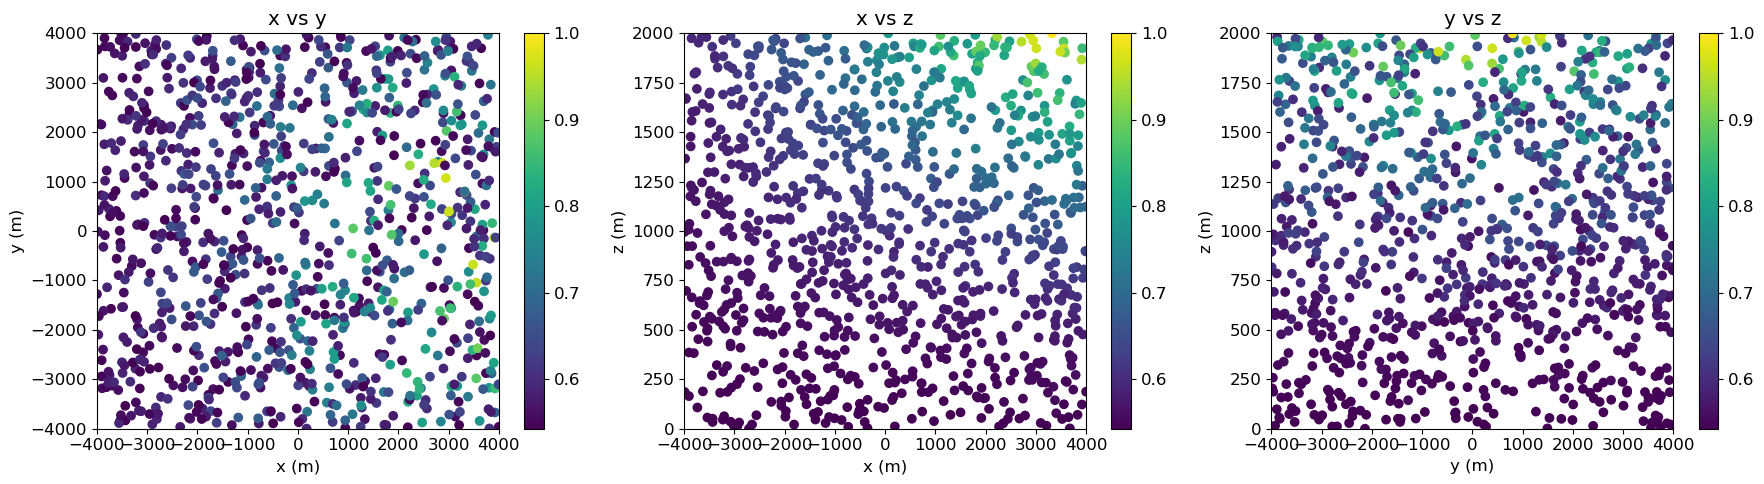

Undirected Monte Carlo best one-source model (domain: x,y in [-4000,4000], z in [0,2000]):
(x,y,z) = (3318.9, 796.7, 1999.9 m), dV = 4.376e+08


In [6]:
num_samples = 1000
np.random.seed(0)

mc_x = np.random.uniform(-4000, 4000, num_samples)
mc_y = np.random.uniform(-4000, 4000, num_samples)
mc_z = np.random.uniform(0, 2000, num_samples)

mc_misfit = np.zeros(num_samples)
mc_dV = np.zeros(num_samples)

for i in range(num_samples):
    x0 = mc_x[i]
    y0 = mc_y[i]
    z0 = mc_z[i]
    uz_mc, ux_mc = mogi_displacement(obs_x, obs_y, x0, y0, z0, 1.0, nu)
    F_mc = -uz_mc * np.cos(inc) + ux_mc * np.sin(inc)
    denom = np.dot(F_mc, F_mc)
    dV_est = np.dot(F_mc, obs_data) / denom if denom != 0 else 0.0
    mc_dV[i] = dV_est
    model = dV_est * F_mc
    mc_misfit[i] = np.sum((obs_data - model)**2)

mc_prob = 1.0 / (mc_misfit + 1e-12)
mc_prob_norm = mc_prob / np.max(mc_prob)

# Plot marginal probability distributions for x, y, and z
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(mc_x, bins=30, weights=mc_prob_norm, color='skyblue')
axs[0].set_title('x marginal')
axs[0].set_xlim([-4000, 4000])
axs[1].hist(mc_y, bins=30, weights=mc_prob_norm, color='salmon')
axs[1].set_title('y marginal')
axs[1].set_xlim([-4000, 4000])
axs[2].hist(mc_z, bins=30, weights=mc_prob_norm, color='lightgreen')
axs[2].set_title('z marginal')
axs[2].set_xlim([0, 2000])
plt.tight_layout()
plt.show()

# Plot pairwise covariance scatter plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sc = axs[0].scatter(mc_x, mc_y, c=mc_prob_norm, cmap='viridis')
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('y (m)')
axs[0].set_xlim([-4000, 4000])
axs[0].set_ylim([-4000, 4000])
axs[0].set_title('x vs y')
fig.colorbar(sc, ax=axs[0])
sc = axs[1].scatter(mc_x, mc_z, c=mc_prob_norm, cmap='viridis')
axs[1].set_xlabel('x (m)')
axs[1].set_ylabel('z (m)')
axs[1].set_xlim([-4000, 4000])
axs[1].set_ylim([0, 2000])
axs[1].set_title('x vs z')
fig.colorbar(sc, ax=axs[1])
sc = axs[2].scatter(mc_y, mc_z, c=mc_prob_norm, cmap='viridis')
axs[2].set_xlabel('y (m)')
axs[2].set_ylabel('z (m)')
axs[2].set_xlim([-4000, 4000])
axs[2].set_ylim([0, 2000])
axs[2].set_title('y vs z')
fig.colorbar(sc, ax=axs[2])
plt.tight_layout()
plt.show()

best_idx = np.argmin(mc_misfit)
best_undirected = (mc_x[best_idx], mc_y[best_idx], mc_z[best_idx], mc_dV[best_idx])
print("Undirected Monte Carlo best one-source model (domain: x,y in [-4000,4000], z in [0,2000]):")
print(f"(x,y,z) = ({best_undirected[0]:.1f}, {best_undirected[1]:.1f}, {best_undirected[2]:.1f} m), dV = {best_undirected[3]:.3e}")


## 6. Inversion Approach 3: Directed Monte Carlo Inversion (One-Source Model)

Finally, we perform a directed Monte Carlo inversion. We draw 1000 candidate sets from a Gaussian proposal centered on [0,0,1000] m (with standard deviations of 500 m for x and y, and 200 m for z) and clip them to the inversion domain (x,y ∈ [-4000,4000] m, z ∈ [0,2000] m). For each candidate a linear inversion for dV is performed and the misfit computed. Then, marginal probability distributions and pairwise covariance scatter plots are produced (with axes set to the inversion domain), and the best model parameters are printed.

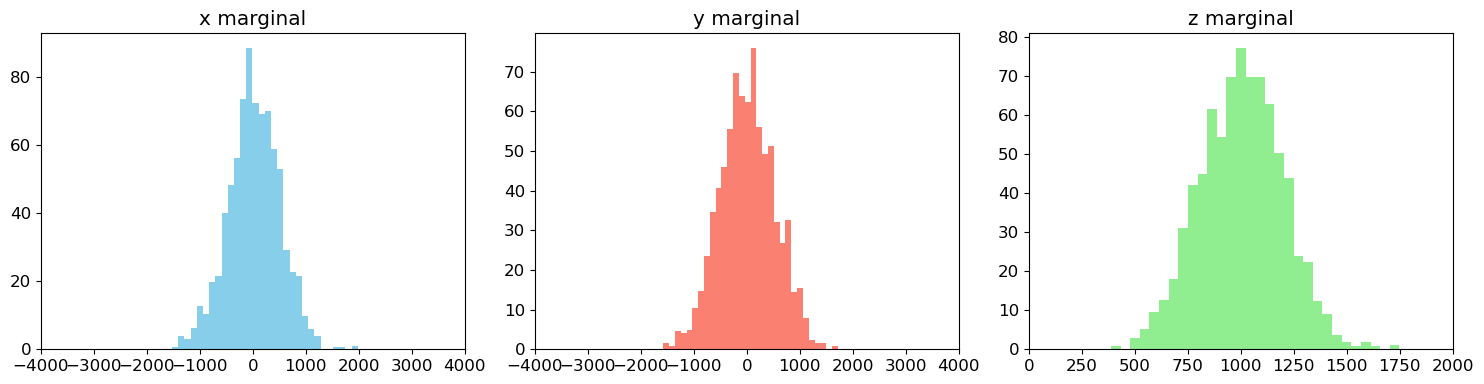

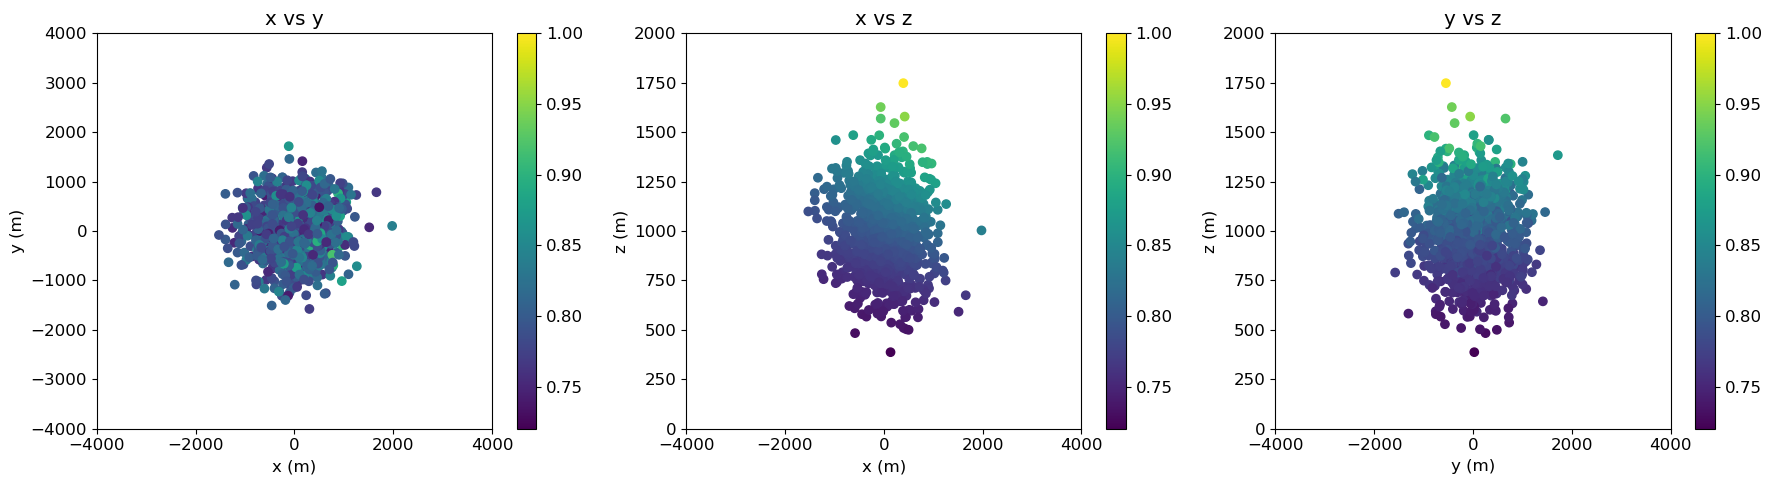

Directed Monte Carlo best one-source model (domain: x,y in [-4000,4000], z in [0,2000]):
(x,y,z) = (397.3, -549.1, 1748.0 m), dV = 3.064e+08


In [7]:
num_samples_dir = 1000
np.random.seed(1)

mc_x_dir = np.clip(np.random.normal(0, 500, num_samples_dir), -4000, 4000)
mc_y_dir = np.clip(np.random.normal(0, 500, num_samples_dir), -4000, 4000)
mc_z_dir = np.clip(np.random.normal(1000, 200, num_samples_dir), 0, 2000)

mc_misfit_dir = np.zeros(num_samples_dir)
mc_dV_dir = np.zeros(num_samples_dir)

for i in range(num_samples_dir):
    x0 = mc_x_dir[i]
    y0 = mc_y_dir[i]
    z0 = mc_z_dir[i]
    uz_dm, ux_dm = mogi_displacement(obs_x, obs_y, x0, y0, z0, 1.0, nu)
    F_dm = -uz_dm * np.cos(inc) + ux_dm * np.sin(inc)
    denom = np.dot(F_dm, F_dm)
    dV_est = np.dot(F_dm, obs_data) / denom if denom != 0 else 0.0
    mc_dV_dir[i] = dV_est
    model = dV_est * F_dm
    mc_misfit_dir[i] = np.sum((obs_data - model)**2)

mc_prob_dm = 1.0 / (mc_misfit_dir + 1e-12)
mc_prob_dm_norm = mc_prob_dm / np.max(mc_prob_dm)

# Plot marginal distributions for directed MC
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(mc_x_dir, bins=30, weights=mc_prob_dm_norm, color='skyblue')
axs[0].set_title('x marginal')
axs[0].set_xlim([-4000, 4000])
axs[1].hist(mc_y_dir, bins=30, weights=mc_prob_dm_norm, color='salmon')
axs[1].set_title('y marginal')
axs[1].set_xlim([-4000, 4000])
axs[2].hist(mc_z_dir, bins=30, weights=mc_prob_dm_norm, color='lightgreen')
axs[2].set_title('z marginal')
axs[2].set_xlim([0, 2000])
plt.tight_layout()
plt.show()

# Plot pairwise covariance scatter plots for directed MC
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sc = axs[0].scatter(mc_x_dir, mc_y_dir, c=mc_prob_dm_norm, cmap='viridis')
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('y (m)')
axs[0].set_xlim([-4000, 4000])
axs[0].set_ylim([-4000, 4000])
axs[0].set_title('x vs y')
fig.colorbar(sc, ax=axs[0])
sc = axs[1].scatter(mc_x_dir, mc_z_dir, c=mc_prob_dm_norm, cmap='viridis')
axs[1].set_xlabel('x (m)')
axs[1].set_ylabel('z (m)')
axs[1].set_xlim([-4000, 4000])
axs[1].set_ylim([0, 2000])
axs[1].set_title('x vs z')
fig.colorbar(sc, ax=axs[1])
sc = axs[2].scatter(mc_y_dir, mc_z_dir, c=mc_prob_dm_norm, cmap='viridis')
axs[2].set_xlabel('y (m)')
axs[2].set_ylabel('z (m)')
axs[2].set_xlim([-4000, 4000])
axs[2].set_ylim([0, 2000])
axs[2].set_title('y vs z')
fig.colorbar(sc, ax=axs[2])
plt.tight_layout()
plt.show()

best_idx_dm = np.argmin(mc_misfit_dir)
best_directed = (mc_x_dir[best_idx_dm], mc_y_dir[best_idx_dm], mc_z_dir[best_idx_dm], mc_dV_dir[best_idx_dm])
print("Directed Monte Carlo best one-source model (domain: x,y in [-4000,4000], z in [0,2000]):")
print(f"(x,y,z) = ({best_directed[0]:.1f}, {best_directed[1]:.1f}, {best_directed[2]:.1f} m), dV = {best_directed[3]:.3e}")


### Summary

This notebook:

- Generates synthetic InSAR data for a one‑source Mogi model at 1 km depth on a 10 km × 10 km grid (50 m spacing), with the source calibrated for 20 cm uplift directly above it.
- Converts displacements to radar LOS for ascending and descending geometries (40° incidence) and plots the clean data.
- Adds noise using a power‑law noise model (with adjustable parameters `noise_exponent` and `noise_amplitude`) and plots the noisy data.
- Downsamples the interferograms to 500 m spacing (each data point is shown as a square with no gaps).
- Conducts inversions using three approaches (grid search, undirected Monte Carlo, directed Monte Carlo) over the inversion domain (x,y: -4000 to 4000 m, z: 0 to 2000 m) with a linear inversion for the source strength (dV).
    - The grid search finds the best model for each candidate depth and then the overall best model; using that, the observed, predicted, and residual LOS fields (for both ascending and descending) are plotted.
    - The undirected Monte Carlo method uses 1000 uniform samples and plots weighted marginal probability distributions and covariance scatter plots over the entire domain, then prints the best model.
    - The directed Monte Carlo method uses 1000 Gaussian-sampled candidates (clipped to the domain) and similarly plots marginal and covariance plots and prints the best model.

All plots for the marginal distributions and covariance are set to horizontal coordinates from -4000 to 4000 m and vertical coordinate from 0 to 2000 m.

Feel free to adjust the parameters as needed.